# Example Single particle tracking

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [40]:
import numpy as np
import torch
from deepymod_torch.library_function import *
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import *
from deepymod_torch.sparsity import *

import matplotlib.pyplot as plt
from scipy.io import loadmat
plt.style.use('seaborn-notebook')

np.random.seed(40)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def advection_diffusion_random_walk(walk_params, traj_params, initial_conditions):
    num_steps, num_walkers, dt = walk_params
    Diff, v = traj_params

    steps = np.random.normal(loc=v*dt, scale=np.sqrt(2*Diff*dt), size=(num_steps, num_walkers))
    trajectory = np.concatenate((initial_conditions,initial_conditions+np.cumsum(np.array(steps), axis=0)), axis=0)
    time = np.arange(num_steps + 1) * dt

    return time, trajectory

In [204]:
n_w = 20
time_vec, x_vec = advection_diffusion_random_walk([1000,n_w,3],[1,0.1],np.zeros((1,n_w)))

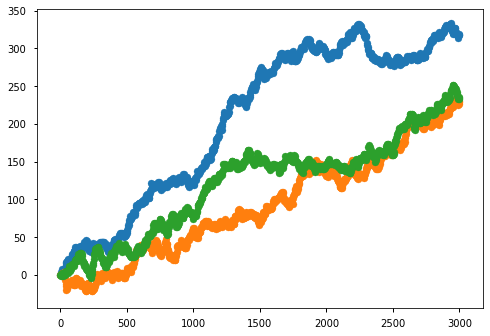

In [205]:
plt.scatter(time_vec,x_vec[:,0])
plt.scatter(time_vec,x_vec[:,1])
plt.scatter(time_vec,x_vec[:,2])

In [206]:
m =50
L_cuts = np.int(x_vec.shape[0]/m)
x_array = x_vec[0:L_cuts][:,1:]

In [207]:
for i in range(1,m):
    temp_array_x= x_vec[i*L_cuts:(i+1)*L_cuts] - x_vec[i*L_cuts]
    x_array= np.hstack((x_array,temp_array_x[:,1:]))

In [208]:
histo=np.histogram(x_array[0],bins=50,range=[-5,5])
U = np.empty(histo[0].shape).flatten()
x_m = histo[1].flatten()[:-1]
X_m= np.empty(x_m.shape).flatten()
T = np.empty(x_m.shape).flatten()

In [209]:
for t in range(1,len(x_array)):
    histo=np.histogram(x_array[t],bins=50,range=[-5,5])
    u = histo[0].flatten()
    x_m = histo[1].flatten()[:-1]
    t = t*np.ones_like(x_m).flatten()
    X_m = np.vstack([X_m,x_m.flatten()])
    T = np.vstack([T,t])
    U = np.vstack([U,u])
X_m= X_m[1:]
T = T[1:]
U = U[1:]

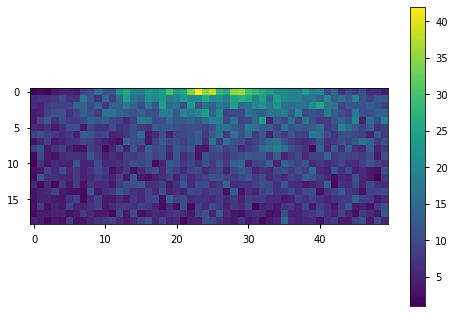

In [210]:
plt.imshow(U)
plt.colorbar()

Next, we prepare the dataset. We load 3 data sets with different diffusion coefficients (D = 1, 0.4 and 0.2) 

In [211]:
x_1 = X_m
t_1 = T
y_1 = U/10

y= y.reshape((y.size, 1)).astype('float32')

In [212]:
X = np.transpose((t_1.flatten(),x_1.flatten()))
y = np.transpose((y_1.flatten(),y_1.flatten()))

In [213]:
y.size

1900

In [214]:
number_of_samples = 250

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [215]:
print(X_train.shape, y_train.shape)

torch.Size([250, 2]) torch.Size([250, 2])


## Configure the neural network

We now setup the options for DeepMoD. There's as few dictionaries to fill, starting with the 'optim config', which sets the maximal number of iterations and the amplitude of the $L_1$ penalty

In [216]:
optim_config = {'lambda': 10**-5, 'max_iterations': 50001}

Next we choose the size of the neural network 

In [217]:
network_config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 3, 'output_dim': y_train.shape[1]}

DeepMoD accepts any arbitrary library function and any options for it can be given through *the library_config*. The library function for the burgers case accepts a maximum order for the polynomial and derivative terms.

In [218]:
library_config = {'type': library_1D_in_group_b, 'poly_order': 1, 'diff_order': 2}

## Run DeepMoD 

In [219]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

2


In [ ]:
time_deriv_list, theta_list, coeff_vector_list = train_group(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 3.2E+00 2.8E+00 4.0E-01 6.0E-04
tensor([[-0.0458],
        [ 0.3492],
        [-1.7981],
        [-0.8159],
        [-0.6976],
        [ 1.6888]], requires_grad=True)
tensor([[ 0.5556],
        [ 0.2349],
        [ 0.0656],
        [-0.6119],
        [-1.3302],
        [-1.5794]], requires_grad=True)
5000 1.2E-01 1.2E-01 3.2E-03 1.0E-04
tensor([[ 0.0735],
        [-0.3550],
        [ 0.0089],
        [-0.1231],
        [ 0.2287],
        [-0.0118]], requires_grad=True)
tensor([[ 0.0783],
        [-0.3581],
        [ 0.0091],
        [-0.1282],
        [ 0.2327],
        [-0.0121]], requires_grad=True)


In [12]:
scaled_coeff_vector_list = [scaling(coeff_vector, theta, time_deriv) for coeff_vector, theta , time_deriv in zip(coeff_vector_list, theta_list, time_deriv_list)]

In [13]:
sparse_coeff_vector_list, sparsity_mask_list = zip(*[threshold(scaled_coeff_vector, coeff_vector) for scaled_coeff_vector, coeff_vector in zip(scaled_coeff_vector_list, coeff_vector_list)])

In [14]:
sparsity_mask_list

(tensor([2]), tensor([2]), tensor([2]), tensor([2]))

In [15]:
optim_config = {'lambda': 10**-20, 'max_iterations': 20001}

In [16]:
time_deriv_list_final, theta_list_final, coeff_vector_list_final = train_group(X_train, y_train, network, sparse_coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 3.1E-05 3.0E-05 8.4E-07 4.0E-20
tensor([[0.8966]], requires_grad=True)
tensor([[0.2016]], requires_grad=True)
tensor([[0.3946]], requires_grad=True)
tensor([[0.6275]], requires_grad=True)
5000 2.0E-06 1.5E-06 4.4E-07 4.0E-20
tensor([[0.9279]], requires_grad=True)
tensor([[0.1983]], requires_grad=True)
tensor([[0.3909]], requires_grad=True)
tensor([[0.6282]], requires_grad=True)
10000 4.0E-07 2.8E-07 1.2E-07 4.0E-20
tensor([[0.9153]], requires_grad=True)
tensor([[0.1995]], requires_grad=True)
tensor([[0.3907]], requires_grad=True)
tensor([[0.6138]], requires_grad=True)
15000 5.0E-07 3.9E-07 1.1E-07 4.0E-20
tensor([[0.8946]], requires_grad=True)
tensor([[0.2005]], requires_grad=True)
tensor([[0.3890]], requires_grad=True)
tensor([[0.6069]], requires_grad=True)


KeyboardInterrupt: 

In [25]:
X_all = torch.tensor(X, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all).detach().numpy()

In [26]:
prediction_full[:,0].reshape((201,201))

array([[-0.01487283, -0.01357602, -0.01218428, ...,  0.08473535,
         0.08481824,  0.08490599],
       [-0.01489349, -0.01358862, -0.01218563, ...,  0.08578973,
         0.08587719,  0.08596976],
       [-0.01491517, -0.01360179, -0.01218683, ...,  0.08685237,
         0.08694463,  0.08704212],
       ...,
       [ 0.03496511,  0.034522  ,  0.03436208, ...,  0.09208208,
         0.09216569,  0.0922498 ],
       [ 0.03490607,  0.03447638,  0.03432567, ...,  0.09150217,
         0.09158775,  0.09167333],
       [ 0.03484775,  0.03443064,  0.03428841, ...,  0.09093636,
         0.09102473,  0.09111258]], dtype=float32)

In [39]:
test= prediction_full[:,3].reshape((201,201))

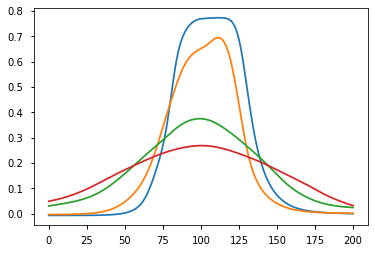

In [37]:
plt.plot(test[:,1])
plt.plot(test[:,10])
plt.plot(test[:,50])
plt.plot(test[:,100])

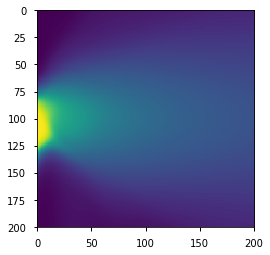

In [30]:
plt.imshow(prediction_full[:,3].reshape((201,201)), aspect=1)

In [77]:
time_deriv_list, theta = library_1D_in(X_train, prediction, library_config)

In [78]:
y_reg = time_deriv_list[0].detach().numpy()
x_reg = theta.detach().numpy()

In [79]:
np.linalg.lstsq(x_reg,y_reg,rcond=None)

(array([[ 1.01022534e-01],
        [ 8.01657885e-03],
        [ 1.61606614e-02],
        [ 1.19942088e-04],
        [ 9.29686939e-06],
        [-1.57570746e-02],
        [-8.46816242e-01],
        [-3.48056555e-02],
        [-8.19199078e-04],
        [-5.23904100e-06]], dtype=float32),
 array([37180.695], dtype=float32),
 10,
 array([7.6361475e+05, 3.1920612e+05, 2.2900121e+04, 9.6409893e+03,
        5.7146167e+02, 5.0050757e+02, 7.1360893e+01, 4.8615910e+01,
        3.0338158e+01, 2.5171886e+01], dtype=float32))

In [80]:
vec =np.linalg.lstsq(x_reg,y_reg,rcond=None)[0]

In [81]:
coeff_vector = [torch.tensor(vec, dtype=torch.float32, requires_grad=True)] 

In [86]:
coeff_vector_list

[tensor([[ 0.2931],
         [ 0.7618],
         [ 1.7404],
         [ 0.6688],
         [ 0.4718],
         [ 0.7023],
         [-1.8055],
         [ 0.4180],
         [-0.9910],
         [-1.9994]], requires_grad=True)]

In [83]:
X_all = torch.tensor(X, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all)

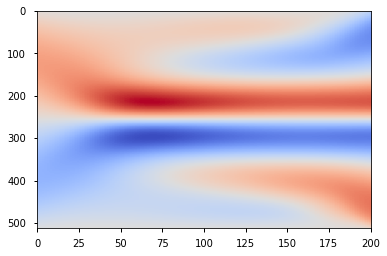

In [84]:

plt.imshow(prediction_full.detach().numpy().reshape(513,201), aspect='auto', cmap='coolwarm')

In [85]:
optim_config = {'lambda': 10**-5, 'max_iterations': 5000, 'type': 'full'}

In [87]:
time_deriv_list, theta, coeff_vector_list = train(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 8.0E+08 2.0E-04 8.0E+08 7.0E-02
tensor([[ 0.2951],
        [ 0.7638],
        [ 1.7384],
        [ 0.6708],
        [ 0.4738],
        [ 0.7043],
        [-1.8035],
        [ 0.4160],
        [-0.9890],
        [-1.9974]], requires_grad=True)
500 1.4E+03 7.6E-01 1.4E+03 3.0E-03
tensor([[ 0.2987],
        [ 0.7776],
        [ 1.7417],
        [ 0.6796],
        [ 0.4826],
        [ 0.7090],
        [-1.7850],
        [ 0.4027],
        [-0.9794],
        [-1.9865]], requires_grad=True)
1000 5.7E+02 7.7E-01 5.7E+02 2.2E-03
tensor([[ 0.3244],
        [ 0.7770],
        [ 1.7439],
        [ 0.6796],
        [ 0.4824],
        [ 0.7035],
        [-1.7849],
        [ 0.4027],
        [-0.9794],
        [-1.9865]], requires_grad=True)
1500 2.7E+02 7.7E-01 2.7E+02 1.7E-03
tensor([[ 0.3575],
        [ 0.7765],
        [ 1.7455],
        [ 0.6795],
        [ 0.4823],
        [ 0.6992],
        [-1.7849],
        [ 0.4026],
        [-0.9794],
        [-1.9865

KeyboardInterrupt: 

In [68]:
time_deriv_list, theta, coeff_vector_list = train(X_train, y_train, network, coeff_vector, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 6.0E-02 5.6E-02 3.5E-03 1.9E-05
tensor([[-0.0092],
        [ 1.1719],
        [-0.1080],
        [-0.3816],
        [ 0.0055],
        [-0.0671],
        [-1.1829],
        [ 0.1687],
        [-0.0087],
        [-0.0136]], requires_grad=True)
500 2.6E-01 7.9E-02 1.8E-01 1.8E-05
tensor([[-0.0353],
        [ 1.1866],
        [-0.1115],
        [-0.4098],
        [ 0.0027],
        [-0.0328],
        [-1.1152],
        [ 0.2151],
        [ 0.0075],
        [-0.0176]], requires_grad=True)


KeyboardInterrupt: 

In [ ]:
time_deriv_list, theta, coeff_vector_list = train(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

In [23]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD(X_train, y_train, network_config, lib_config, optim_config)

[autoreload of deepymod_torch.neural_net failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/working/src/deepymod_torch/neural_net.py", line 153

NameError: name 'lib_config' is not defined

Now that DeepMoD has converged, it has found the following equation:

In [34]:
print('Final result:')
print(sparse_coeff_vector, sparsity_mask)

Final result:
(tensor([[ 0.0994],
        [-1.0001]], requires_grad=True),) (tensor([2, 5]),)
